# Please don't look here!

This notebook is a mess but contains some tests/code I may pick up later.

For your own sake, don't venture any further :P

In [1]:
import sys
sys.path.insert(0, "../")

import matplotlib.pyplot as plt
import numpy as np
import uq4pk_src as uq4pk

import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

/Users/pjethwa/Astro/Science/uq4pk/mcmc/../uq4pk_src/tsvd_sampler.py:120: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if data_idx is 'all':
/Users/pjethwa/Astro/Science/uq4pk/mcmc/../uq4pk_src/tsvd_sampler.py:244: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if data_idx is 'all':
/Users/pjethwa/Astro/Science/uq4pk/mcmc/../uq4pk_src/tsvd_sampler.py:433: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if data_idx is 'all':
/Users/pjethwa/Astro/Science/uq4pk/mcmc/../uq4pk_src/qp_solvers.py:192: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if which_solver is 'default':
/Users/pjethwa/Astro/Science/uq4pk/mcmc/../uq4pk_src/qp_solvers.py:197: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif which_solver is 'identity_P':
/Users/pjethwa/Astro/Science/uq4pk/mcmc/../uq4pk_src/qp_solvers.py:201: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif which_solver is 'banded_P':
/Users/pjethwa/Astro/Science/uq4pk/mcmc/../uq4pk_src/qp_

# Generate Mock Data

In [15]:
np.random.seed(82011)

In [16]:
snr = 300.
Theta_v_true = np.array([-150., 100., 1., 0., 0., -0.2, 0.05])
dv = 30.
lmd_min, lmd_max = 4000., 5000.

In [17]:
ssps = uq4pk.model_grids.MilesSSP(lmd_min=lmd_min, lmd_max=lmd_max)
df = uq4pk.distribution_function.RandomGMM_DistributionFunction(modgrid=ssps, fill_pars={'n':2,
                                                                                         'logsig_lo':-2,
                                                                                         'logsig_hi':-1.5})
op = uq4pk.observation_operator.ObservationOperator(ssps=ssps, dv=dv)
ybar = op.evaluate(df.F, Theta_v_true)
sigma_y = np.mean(np.abs(ybar))/snr
y = np.random.normal(ybar, sigma_y)

Distribution functions should have shape (12, 53)


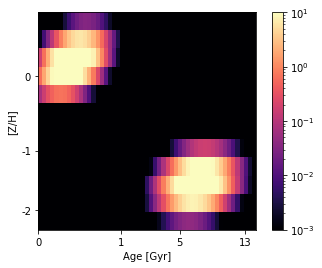

In [18]:
plotter = uq4pk.plotting.Plotter(ssps=ssps, df=df)
plotter.plot_df(view='true', colorbar='true', clim=[1e-3, 10])

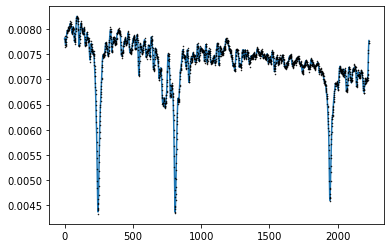

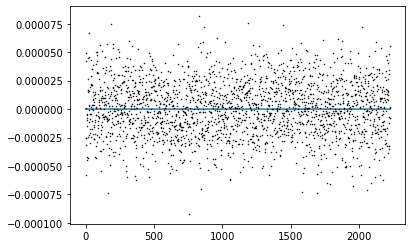

In [19]:
plt.plot(ybar)
plt.plot(y, '.k', ms=1)
plt.show()

plt.plot(ybar-ybar)
plt.plot(y-ybar, '.k', ms=1)
plt.show()

## Pre-processing of SSP templates

Get the SSP templates, multiplied by volume element

In [20]:
m = ssps.F_tilde_s.shape[0]
FXw = np.reshape(ssps.F_tilde_s * ssps.delta_zt, (m,-1))

We will demo SVD-MCMC on the problem where LOSVD parameters are fixed. So let's pre-convolve these by the true LOSVD,

In [21]:
V, sigma, h, M = op.unpack_Theta_v(Theta_v_true)
F_losvd = op.losvd.evaluate_fourier_transform(
    op.H_coeffs,
    V,
    sigma,
    h,
    M,
    op.omega)
FXw_conv = (FXw.T * F_losvd).T
X = np.fft.irfft(FXw_conv, op.ssps.n_fft, axis=0)

Check that the pre-convolved templates $X$ dotted with the true density $f$ re-produces the data,

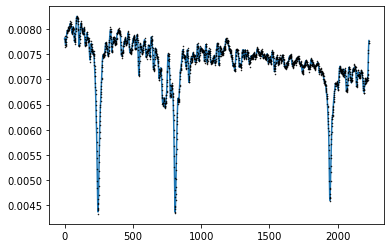

In [22]:
plt.plot(np.dot(X, df.beta))
plt.plot(y, '.k', ms=1)
plt.show()

## Problem Setup

Our problem is now of the form,

$$
y = X \beta + \epsilon
$$

where:

- $X$ is matrix of SSP templates multiplied by the volume element $\Delta t \Delta z$
- $\beta$ is the associated vector of weights, i.e. the discretized and flattened version of $f(t,z)$.

*Notation:* I've chosen $X$ and $\beta$ as they seem to be standard notation for linear regression. Using $\beta$ may also useful when we want to distinguish between 1D and 2D representations of $f$.

We first normalise and center the matrix $X$ before computing the SVD. This makes the SVD equivalent to PCA, ensuring that the singular-values decay as fast as possible,

Let $x_j$ be the $j$'th column of $X$ (i.e. the j'th SSP template). Define the normalised template

$$
\tilde{x}_j = \frac{x_j \sum y}{\sum x_j}
$$

where we (i) multiply by the sum of the data in order that regression coefficients remain order unity, and (ii) divide by sum of the template so that templates are on the same scale before we do the SVD. Also define the normalised regression coefficients,

$$
\begin{align}
\tilde{\beta} &= \left[\beta_1 \frac{\sum x_1}{\sum y}, ..., \beta_p \frac{\sum x_p}{\sum y}\right] \\
&:= D \beta
\end{align}
$$

where D is diagonal matrix with $\frac{\sum x_i}{\sum y}$ along the diagonal. The regression is now,

$$
y = [\tilde{x}_1, ...,  \tilde{x}_p] \tilde{\beta} + \epsilon.
$$

Define the column mean

$$
\mu = \frac{1}{p} \sum_{j=1}^{p} \tilde{x}_j
$$

where $p$ is the number of templates. Introduce the centered and normalised matrix

$$
\tilde{X} = [\tilde{x}_1-\mu_x, ...,  \tilde{x}_p-\mu_x]
$$

so the regression becomes 

$$
y = \alpha \mu_x + \tilde{X} \tilde{\beta} + \epsilon
$$

where

$$
\alpha = \sum \tilde{\beta}.
$$

Since we scaled by the sum of the data, we can expect $\alpha$ to be around 1,

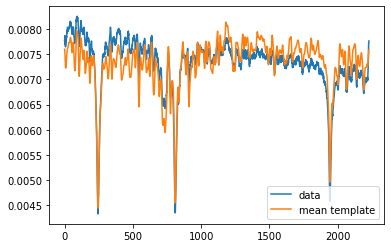

In [23]:
sum_x_j = np.sum(X, 0)
X_tmp = np.sum(y) * X/sum_x_j
mu = np.mean(X_tmp, 1)
X_tilde = (X_tmp.T - mu).T
D = np.diag(sum_x_j/np.sum(y))

plt.plot(y, label='data')
plt.plot(mu, label='mean template')
plt.legend()

In [151]:
np.min(sum_x_j), np.max(sum_x_j) 

(0.0014333809755005629, 0.08786083883751056)

Next get the SVD of $\tilde{X}$,

$$
\tilde{X} = U \Sigma V^T.
$$

We will keep the first $q<<p$ factors

$$
\tilde{X} \approx Z H^T
$$

where $Z = U[:,:q] \Sigma[:q, :q]$ and $H = V[:,:q]$. The regression now becomes,

$$
y = \alpha \mu_x + Z \eta + \epsilon
$$

where the $q$ dimensional vector of coefficients $\eta$ is related to the original regression coefficients via

$$
\eta = H^T \tilde{\beta}.
$$

In [117]:
U, Sig, VT = np.linalg.svd(X_tilde)

In [118]:
q = 15 # just pick some value for now
Z = np.dot(U[:,:q], np.diag(Sig[:q]))
H = VT[:q,:]

## What prior/regulariser?

Given a prior 

$$
\beta \sim \mathcal N_{\geq  \mathbf{0}}(0, \boldsymbol{\Sigma}_\beta),
$$

the implied prior on $\tilde{\beta}=D\beta$ is

$$
\tilde{\beta} \sim \mathcal N_{\geq  \mathbf{0}}(0, D \boldsymbol{\Sigma}_\beta D).
$$

For now let's stick with Fabian's choice for $\boldsymbol{\Sigma}_\beta$: Ornstein-Uhlenbeck covariance with regualrisation parameter $= \mathrm{snr} \cdot 1000$. To get this matrix, lets use Fabian's code,

In [28]:
from uq4pk_fit.inference import StatModel
from simulate_data import load_experiment_data
data = load_experiment_data("experiment_data")
forward_operator = data.get_forward_operator()
model = StatModel(y=y, y_sd=np.ones_like(y)*sigma_y, forward_operator=forward_operator)

/Users/pjethwa/miniconda3/envs/dcdirect/lib/python3.9/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


Distribution functions should have shape (12, 53)
Distribution functions should have shape (12, 53)


In [29]:
regularisation_parameter = 1000.*snr
Sigma_beta = (1./regularisation_parameter) * np.dot(model.P1.mat, model.P1.mat.T)
Sigma_beta_tilde = np.dot(D, Sigma_beta)
Sigma_beta_tilde = np.dot(Sigma_beta_tilde, D)

In [31]:
np.linalg.cond(Sigma_beta), np.linalg.cond(Sigma_beta_tilde)

(315.72279899976536, 204402.80372435926)

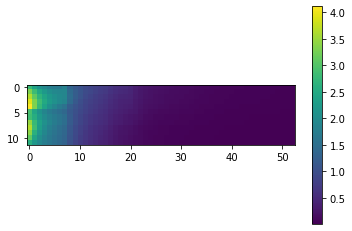

In [39]:
plt.imshow(np.sum(ssps.X, 0).reshape(ssps.par_dims))
plt.colorbar()

In [40]:
np.min(np.sum(ssps.X, 0)), np.max(np.sum(ssps.X, 0))

(0.011630638452970743, 4.115047989180312)

# Inference

## Original model

In [ ]:
def full_model(p, X, sigma_y, mu_beta, Sigma_beta, y_obs=None):
    # to enforce positivity
    beta = numpyro.sample("beta", dist.TruncatedNormal(0, 10, low=0), sample_shape=(p,))
    # prior
    mvn = dist.MultivariateNormal(mu_beta, Sigma_beta)
    numpyro.factor('prior', mvn.log_prob(beta))
    # likelihood
    nrm = dist.Normal(jnp.dot(X, beta), sigma_y)
    y_obs = numpyro.sample("y_obs", nrm, obs=y_obs)
    return y_obs

In [ ]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(full_model)
full_model_mcmc = MCMC(kernel, num_warmup=500, num_samples=500)

In [ ]:
p = X.shape[1]
full_model_mcmc.run(rng_key_,
                    p,
                    jnp.array(X),
                    sigma_y,
                    jnp.zeros(p),
                    jnp.array(Sigma_beta),
                    y_obs=jnp.array(y))

In [ ]:
full_model_mcmc.print_summary()

This full model has failed completely. Warmup (i.e. calibration of the markov chain parameters) sent the step-size to an unrealistically small value. This avoids 'divergent transitions' i.e. markov steps which do not conserve energy. With such a small step size, chains are highly correlated, so the effective sample size is <1. Also, it took 15 minutes.

Now lets try the SVD model.

### Use the Centered + Low-Rank approximation to $\tilde{X}$

What is the geenrative model for this SVD regression? Given a prior on the regression parameters we can sample $\tilde{\beta} \sim p(\tilde{\beta})$ then transform to 

$$
\alpha = \sum \tilde{\beta},
$$

$$
\eta = H \tilde{\beta},
$$

then finally generate data

$$
p(y | \alpha, \eta ) = \mathcal N (\alpha \mu + Z \eta, \sigma_y) \;\;\;(1)
$$

For this model, the posterior on $\tilde{\beta}$ is given by

$$
\begin{align}
p(\tilde{\beta} | y) &\propto p(\tilde{\beta}) p(y | \tilde{\beta})  \\
&= p(\tilde{\beta}) \int p(y | \eta, \alpha) p(\eta , \alpha | \tilde{\beta}) \; \mathrm{d} \eta \; \mathrm{d} \alpha \;\;\;(2)
\end{align}
$$

Since there is a deterministic mapping from any $\tilde{\beta}$ to a unique $(\eta , \alpha)$, this probability function is a product of delta functions,

$$
p(\eta , \alpha | \tilde{\beta}) = \delta(\eta - H \tilde{\beta}) \delta(\alpha - \sum \tilde{\beta}) \;\;\;(3).
$$

Inserting equations (1) and (3) into (2) gives,

$$
p(\tilde{\beta} | y) \propto p(\tilde{\beta}) p\left(y | \sum \tilde{\beta} \mu + ZH \tilde{\beta}, \sigma_y\right)
$$

Essentially, we have taken the original regrssion $y = X\beta$, rescaled and center to transform $X \rightarrow (\tilde{X},\mu)$, then take a low-rank approximaition of $\tilde{X} \approx ZH$, where we have dropped all but the first $q$ singular values. The dimensionality of the model is unchanged i.e. $ZH$ is still an $(n,p)$ matrix.

How will (Hamiltonian) MCMC cope with this?

In [ ]:
def low_rank_model(p, mu, ZH, sigma_y, mu_beta_tilde, Sigma_beta_tilde, y_obs=None):
    # to enforce positivity
    beta_tilde = numpyro.sample("beta", dist.TruncatedNormal(0, 10, low=0), sample_shape=(p,))
    # prior
    mvn = dist.MultivariateNormal(mu_beta_tilde, Sigma_beta_tilde)
    numpyro.factor('prior', mvn.log_prob(beta_tilde))
    # likelihood
    nrm = dist.Normal(np.sum(beta_tilde)*mu+jnp.dot(ZH, beta_tilde), sigma_y)
    y_obs = numpyro.sample("y_obs", nrm, obs=y_obs)
    return y_obs

In [ ]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(low_rank_model)
low_rank_mcmc = MCMC(kernel, num_warmup=500, num_samples=500)

In [ ]:
p = X.shape[1]
low_rank_mcmc.run(rng_key_,
                  p,
                  jnp.array(mu),
                  jnp.dot(Z,H),
                  sigma_y,
                  jnp.zeros(p),
                  jnp.array(Sigma_beta_tilde),
                  y_obs=jnp.array(y))

In [ ]:
low_rank_mcmc.print_summary()

OK - this time the step size calibrated to a reasonable value. Effective sample sizes are high (>500), and chains are converged (all rhat=1). But... it took 18 minutes. Let' check - does it work?

In [ ]:
smp = low_rank_mcmc.get_samples()

In [ ]:
beta_tilde = smp['beta']
y_smp = mu[np.newaxis,:] * np.sum(beta_tilde,1)[:,np.newaxis] + np.dot(np.dot(Z,H), beta_tilde.T).T
lo, med, hi = np.percentile(y_smp, [1,50,99], 0)

In [ ]:
plt.fill_between(ssps.w, lo, hi, color='c', alpha=0.5)
plt.plot(ssps.w, med, color='b', lw=1)
plt.plot(ssps.w, y, '.k', ms=1)

In [ ]:
plt.fill_between(ssps.w, lo-med, hi-med, color='c', alpha=0.5)
plt.plot(ssps.w, med-med, color='b', lw=1)
plt.plot(ssps.w, ybar - med, '-k', lw=0.5)
plt.plot(ssps.w, y - med, '.k', ms=1)

OK - it fit's the data! Centering and rescaling has made things better behaved. Can we make it faster?

## Sampling in lower dimensions

What if we actually sample in lower dimensions? The $q$ dimensional vector of regression coefficients $\eta$, and the intercept $\alpha$? The model is

$$
\begin{align}
p(\alpha) &\sim \mathcal N (0, \sigma_\alpha) \\
p(\eta) &\sim N (\mathbb{1}_q, \sigma_\eta^2 I_q) \\
p(y | \alpha, \eta ) &\sim \mathcal N (\alpha \mu + Z \eta, \sigma_y) \\
\end{align}
$$

We can sample the $q+1$ dimensional posterior $p(\alpha, \eta | y)$. By the nature of the SVD, this will be an uncorrelated multivariate normal, which can be summarised by posterior parameters $[\mu_\alpha, \mu_\eta]$ and $[\sigma_\alpha, \sigma_\eta]$ (all of which depend on the data $y$),

$$
p(\alpha, \eta | y) = \mathcal N ([\mu_\alpha, \mu_\eta] , \mathrm{diag}([\sigma_\alpha, \sigma_\eta]) ).
$$

Then how do we infer $\tilde{\beta}$? In the model above, we have defined a prior on $p(\tilde{\beta})$, then could sample this, then generate $(\alpha,\eta)$, then generate $y$. *But* now having defined explicit priors $p(\alpha)$ and $p(\eta)$, there is no explicit disbtribution from which we can sample $\tilde{\beta}$. Nevertheless, we can still define a probability function $\pi(\tilde{\beta})$ which combines the posterior $p(\alpha, \eta | y)$ and a prior $p(\tilde{\beta})$,

$$
\begin{align}
\pi(\tilde{\beta}) &\approx p(\tilde{\beta} | y) \\
\log \pi(\tilde{\beta}) &= \log p(\tilde{\beta}) + \log \mathcal N \left( \sum \tilde{\beta} ; \mu_\alpha, \sigma_\alpha \right) + \log \mathcal N \left( H \tilde{\beta} ; \mu_\eta, \sigma_\eta \right).
\end{align}
$$

Sampling this model is in two parts. First sample the posterior $p(\alpha, \eta | y)$,

In [41]:
def svd_lowdim_datafit_model(q, mu, Z, sigma_y, y_obs=None):
    alpha = numpyro.sample("alpha", dist.Normal(1, 0.1))
    eta = numpyro.sample("eta", dist.Normal(0, 0.1), sample_shape=(q,))
    ybar = alpha*mu + jnp.dot(Z, eta)
    nrm = dist.Normal(loc=ybar, scale=sigma_y)
    y_obs = numpyro.sample("y_obs", nrm, obs=y_obs)
    return y_obs

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(svd_lowdim_datafit_model)
svd_lowdim_datafit_mcmc = MCMC(kernel, num_warmup=500, num_samples=500)

In [42]:
svd_lowdim_datafit_mcmc.run(rng_key_, q, mu, Z, sigma_y, y_obs=y)

sample: 100%|█████████████| 1000/1000 [00:06<00:00, 144.82it/s, 127 steps of size 4.62e-03. acc. prob=0.94]


In [43]:
svd_lowdim_datafit_mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      1.00      0.00      1.00      1.00      1.00    510.73      1.00
    eta[0]     -0.01      0.00     -0.01     -0.01     -0.01    421.06      1.00
    eta[1]     -0.00      0.00     -0.00     -0.00      0.00    627.05      1.00
    eta[2]     -0.03      0.00     -0.03     -0.03     -0.03    335.19      1.00
    eta[3]      0.00      0.00      0.01      0.00      0.01    592.23      1.00
    eta[4]      0.01      0.00      0.01      0.01      0.01    685.38      1.00
    eta[5]      0.01      0.00      0.01      0.01      0.01    310.51      1.00
    eta[6]     -0.00      0.00     -0.00     -0.00      0.00    177.69      1.00
    eta[7]      0.01      0.00      0.01      0.01      0.02    474.06      1.00
    eta[8]      0.03      0.00      0.03      0.03      0.04    635.59      1.00
    eta[9]      0.04      0.00      0.04      0.03      0.04    117.70      1.00
   eta[10]      0.03      0

In [44]:
smp = svd_lowdim_datafit_mcmc.get_samples()

In [45]:
y_smp = mu[np.newaxis,:] * smp['alpha'][:,np.newaxis] + np.dot(Z, smp['eta'].T).T
lo, med, hi = np.percentile(y_smp, [1,50,99], 0)

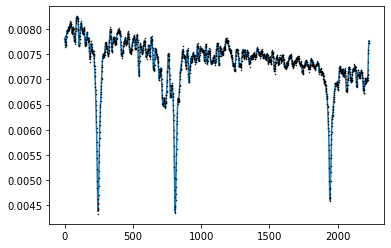

In [46]:
plt.plot(med)
plt.plot(y, '.k', ms=1)

In [56]:
smp = svd_lowdim_deproject_mcmc.get_samples()

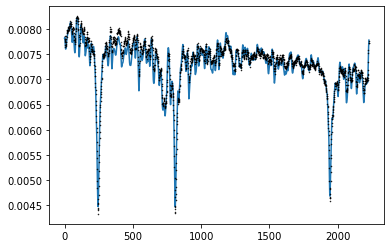

In [57]:
alpha = np.sum(smp['beta_tilde'],1)
eta = np.dot(H, smp['beta_tilde'].T).T
y_smp = alpha[:,np.newaxis]*mu[np.newaxis,:] + np.dot(Z, eta.T).T

lo, med, hi = np.percentile(y_smp, [1,50,99], 0)
plt.plot(med)
plt.plot(y, '.k', ms=1)

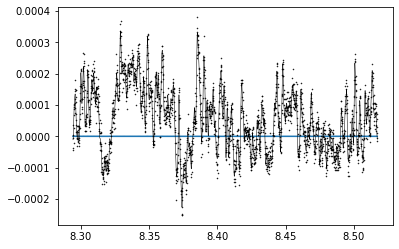

In [58]:
plt.fill_between(ssps.w, lo-med, hi-med, alpha=0.5)
plt.plot(ssps.w, med-med)
plt.plot(ssps.w, ybar-med, '-k', lw=0.5)
plt.plot(ssps.w, y-med, '.k', ms=1)
plt.show()

That worked well, and in 5 seconds! And now let's do the deprojection,

In [47]:
def svd_lowdim_deproject_model(p, mu_eta, sigma_eta, mu_alpha, sigma_alpha, H, mu_beta_tilde, Sigma_beta_tilde):
    # hack for non-negativity
    beta_tilde = numpyro.sample("beta_tilde", dist.TruncatedNormal(0, 10., low=0), sample_shape=(p,))
    # from the datafit
    nrm = dist.Normal(mu_eta, sigma_eta)
    numpyro.factor("likelihood", jnp.sum(nrm.log_prob(jnp.dot(H, beta_tilde))))
    alpha_nrm = dist.Normal(mu_alpha, sigma_alpha)
    numpyro.factor("normalisation", alpha_nrm.log_prob(jnp.sum(beta_tilde)))
    # prior
    beta_prior = dist.MultivariateNormal(mu_beta_tilde, Sigma_beta_tilde)
    numpyro.factor("regulariser", beta_prior.log_prob(beta_tilde))
    return beta_tilde

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(svd_lowdim_deproject_model)
svd_lowdim_deproject_mcmc = MCMC(kernel, num_warmup=500, num_samples=500)

In [48]:
smp = svd_lowdim_datafit_mcmc.get_samples()
mu_alpha, sigma_alpha = np.mean(smp['alpha']), np.std(smp['alpha'])
mu_eta, sigma_eta = np.mean(smp['eta'], 0), np.std(smp['eta'], 0)

In [49]:
mu_alpha, sigma_alpha, mu_eta, sigma_eta, sigma_y

(DeviceArray(0.9999995, dtype=float32),
 DeviceArray(7.1857794e-05, dtype=float32),
 DeviceArray([-0.01233108, -0.00016887, -0.03196489,  0.00498209,
               0.01102533,  0.00687433, -0.00017895,  0.01464721,
               0.03140556,  0.0373495 ,  0.02951606,  0.00749715,
               0.01915762,  0.01013328, -0.00993267], dtype=float32),
 DeviceArray([2.3030369e-05, 2.0565242e-04, 2.6412707e-04, 7.1342214e-04,
              6.6532212e-04, 1.1845524e-03, 1.9846139e-03, 2.6113475e-03,
              3.2717392e-03, 3.2855570e-03, 3.7236128e-03, 4.3528103e-03,
              5.0039040e-03, 5.0976351e-03, 6.0859821e-03], dtype=float32),
 2.4414070515370626e-05)

In [69]:
p = ssps.X.shape[1]
svd_lowdim_deproject_mcmc.run(
    rng_key_, p, mu_eta, sigma_eta, mu_alpha, sigma_alpha, H, jnp.zeros(p), Sigma_beta
)

sample: 100%|█████████████| 1000/1000 [04:19<00:00,  3.85it/s, 1023 steps of size 1.39e-03. acc. prob=0.94]


In [70]:
svd_lowdim_deproject_mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta_tilde[0]      0.00      0.00      0.00      0.00      0.00     53.10      1.00
  beta_tilde[1]      0.00      0.00      0.00      0.00      0.00     83.85      1.00
  beta_tilde[2]      0.00      0.00      0.00      0.00      0.00    262.81      1.00
  beta_tilde[3]      0.00      0.00      0.00      0.00      0.00    119.60      1.00
  beta_tilde[4]      0.00      0.00      0.00      0.00      0.00    249.20      1.00
  beta_tilde[5]      0.00      0.00      0.00      0.00      0.00    150.06      1.00
  beta_tilde[6]      0.00      0.00      0.00      0.00      0.00    111.38      1.00
  beta_tilde[7]      0.00      0.00      0.00      0.00      0.00     42.34      1.01
  beta_tilde[8]      0.00      0.00      0.00      0.00      0.01     40.90      1.00
  beta_tilde[9]      0.00      0.00      0.00      0.00      0.01     69.97      1.00
 beta_tilde[10]      0.00      0.00      0.00      0.

It has converged. How long did it take?

Total time = 5s (datafit) + 4m19 (deprojection).

Previous model = 17m29.

Total speedup = factor 4.

In [71]:
smp = svd_lowdim_deproject_mcmc.get_samples()

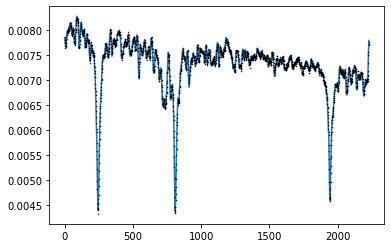

In [72]:
alpha = np.sum(smp['beta_tilde'],1)
eta = np.dot(H, smp['beta_tilde'].T).T
y_smp = alpha[:,np.newaxis]*mu[np.newaxis,:] + np.dot(Z, eta.T).T

lo, med, hi = np.percentile(y_smp, [1,50,99], 0)
plt.plot(med)
plt.plot(y, '.k', ms=1)

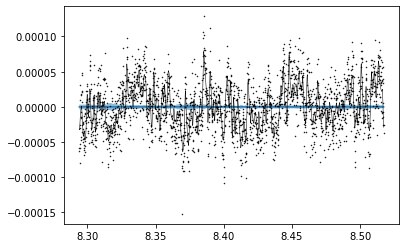

In [73]:
plt.fill_between(ssps.w, lo-med, hi-med, alpha=0.5)
plt.plot(ssps.w, med-med)
plt.plot(ssps.w, ybar-med, '-k', lw=0.5)
plt.plot(ssps.w, y-med, '.k', ms=1)
plt.show()

In [76]:
Dinv = np.diag(np.diag(D)**-1)
beta = np.dot(Dinv, smp['beta_tilde'].T).T

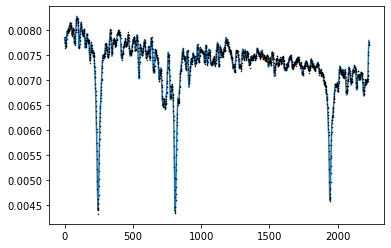

In [78]:
y_smp = np.dot(X, beta.T).T

lo, med, hi = np.percentile(y_smp, [1,50,99], 0)
plt.plot(med)
plt.plot(y, '.k', ms=1)


# Try a different regulariser?

In [80]:
reg = uq4pk.regularisers.FiniteDifference(modgrid=ssps, n=2)

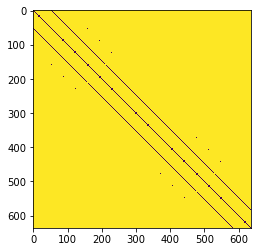

In [84]:
plt.imshow(reg.R==0, interpolation='none')

In [88]:
Rprime = np.dot(np.dot(D, reg.R), D)

In [89]:
np.linalg.cond(reg.R), np.linalg.cond(Rprime)

(16661.955678608105, 2009208.7760643784)

In [87]:
np.linalg.cond(Sigma_beta), np.linalg.cond(Sigma_beta_tilde)

(315.72279899976536, 204402.80372435926)

In [ ]:
Applying D to covariance always increases the condition number

# Do SVD on X directly?

In [ ]:
U, Sig, VT = np.linalg.svd(X_tilde)

In [90]:
U2, Sig2, VT2 = np.linalg.svd(X)

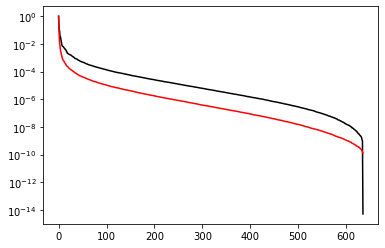

In [94]:
plt.semilogy(Sig/Sig[0], color='k')
plt.semilogy(Sig2/Sig2[0], color='r')

Singular values decay faster for the uncentered/un-normalised SVD

In [95]:
Z2 = np.dot(U2[:,:q], np.diag(Sig2[:q]))
H2 = VT2[:q,:]

In [96]:
XXX2 = np.dot(Z2, H2)

(-0.5, 0.5)

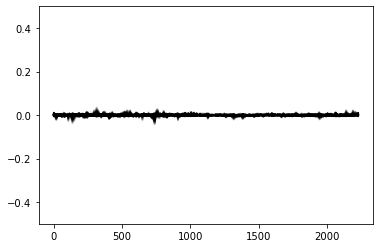

In [115]:
_ = plt.plot((XXX2 - X)/X, '-k', alpha=0.1)
plt.gca().set_ylim(-0.5, 0.5)

(-0.5, 0.5)

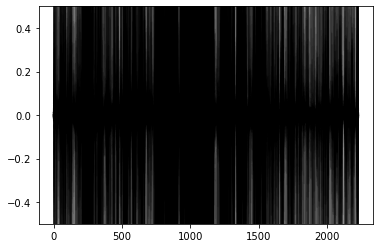

In [116]:
_ = plt.plot((np.dot(Z,H) - X_tilde)/X_tilde, '-k', alpha=0.1)
plt.gca().set_ylim(-0.5, 0.5)

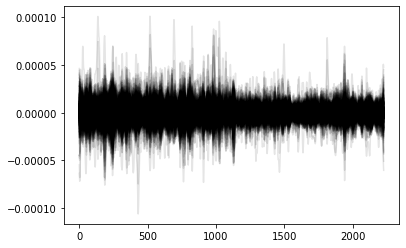

In [119]:
_ = plt.plot((np.dot(Z,H) - X_tilde), '-k', alpha=0.1)

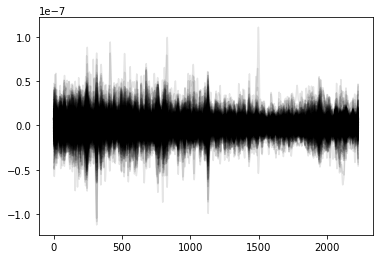

In [120]:
_ = plt.plot((np.dot(Z2,H2) - X), '-k', alpha=0.1)

In [125]:
def svd2_lowdim_datafit_model(q, Z, sigma_y, y_obs=None):
    eta = numpyro.sample("eta", dist.Normal(0, 0.1), sample_shape=(q,))
    ybar = jnp.dot(Z, eta)
    nrm = dist.Normal(loc=ybar, scale=sigma_y)
    y_obs = numpyro.sample("y_obs", nrm, obs=y_obs)
    return y_obs

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(svd2_lowdim_datafit_model)
svd2_lowdim_datafit_mcmc = MCMC(kernel, num_warmup=500, num_samples=500)

In [126]:
svd2_lowdim_datafit_mcmc.run(rng_key_, q, Z2, sigma_y, y_obs=y)

sample: 100%|███████████████| 1000/1000 [00:03<00:00, 261.50it/s, 7 steps of size 4.50e-01. acc. prob=0.89]


In [127]:
svd2_lowdim_datafit_mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]    -30.05      0.00    -30.05    -30.06    -30.05    491.86      1.00
    eta[1]    -15.76      0.03    -15.77    -15.82    -15.72    788.41      1.00
    eta[2]     -0.45      0.09     -0.45     -0.59     -0.31    866.66      1.00
    eta[3]     -0.12      0.10     -0.13     -0.29      0.06    954.29      1.00
    eta[4]     -0.12      0.10     -0.12     -0.30      0.03    435.42      1.00
    eta[5]     -0.12      0.09     -0.12     -0.26      0.03    618.80      1.00
    eta[6]     -0.13      0.10     -0.13     -0.29      0.03    472.10      1.00
    eta[7]     -0.06      0.10     -0.06     -0.21      0.10    432.05      1.00
    eta[8]     -0.04      0.10     -0.04     -0.19      0.12    417.48      1.00
    eta[9]      0.02      0.10      0.02     -0.13      0.18    424.35      1.00
   eta[10]      0.00      0.09      0.00     -0.14      0.17    502.42      1.00
   eta[11]      0.02      0

In [128]:
smp = svd2_lowdim_datafit_mcmc.get_samples()

In [129]:
y_smp = np.dot(Z2, smp['eta'].T).T
lo, med, hi = np.percentile(y_smp, [1,50,99], 0)

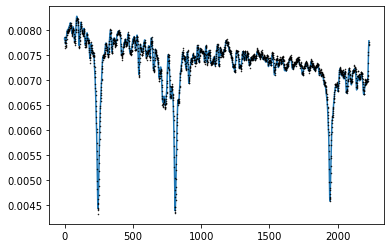

In [130]:
plt.plot(med)
plt.plot(y, '.k', ms=1)

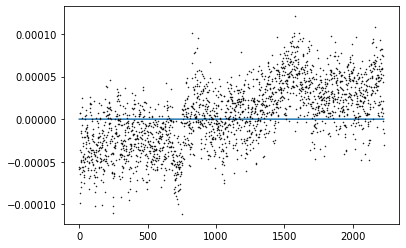

In [131]:
plt.plot(med-med)
plt.plot(y-med, '.k', ms=1)

In [132]:
def svd2_lowdim_datafit_model(q, Z, sigma_y, y_obs=None):
    eta = numpyro.sample("eta", dist.Normal(0, 10), sample_shape=(q,))
    ybar = jnp.dot(Z, eta)
    nrm = dist.Normal(loc=ybar, scale=sigma_y)
    y_obs = numpyro.sample("y_obs", nrm, obs=y_obs)
    return y_obs

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(svd2_lowdim_datafit_model)
svd2_lowdim_datafit_mcmc = MCMC(kernel, num_warmup=500, num_samples=500)

In [133]:
svd2_lowdim_datafit_mcmc.run(rng_key_, q, Z2, sigma_y, y_obs=y)

sample: 100%|███████████████| 1000/1000 [00:03<00:00, 273.68it/s, 7 steps of size 4.19e-01. acc. prob=0.91]


In [134]:
svd2_lowdim_datafit_mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0]    -30.07      0.00    -30.07    -30.07    -30.06    435.69      1.00
    eta[1]    -17.28      0.03    -17.28    -17.33    -17.23    546.58      1.00
    eta[2]     -1.81      0.17     -1.81     -2.09     -1.53    782.64      1.00
    eta[3]     -1.19      0.31     -1.18     -1.76     -0.72    855.52      1.00
    eta[4]     -5.12      0.70     -5.11     -6.29     -4.11    490.13      1.00
    eta[5]     -9.12      0.81     -9.10    -10.27     -7.70   1029.42      1.00
    eta[6]    -22.97      1.22    -22.96    -24.93    -20.95    793.26      1.00
    eta[7]    -20.97      1.88    -20.87    -23.74    -17.72    423.85      1.00
    eta[8]    -21.60      2.30    -21.68    -25.14    -17.61    513.35      1.00
    eta[9]     11.77      2.75     11.73      7.96     17.31    683.75      1.00
   eta[10]      3.82      3.04      3.91     -1.55      8.69    558.69      1.00
   eta[11]     30.19      3

In [135]:
smp = svd2_lowdim_datafit_mcmc.get_samples()

In [136]:
y_smp = np.dot(Z2, smp['eta'].T).T
lo, med, hi = np.percentile(y_smp, [1,50,99], 0)

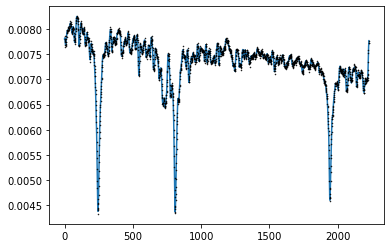

In [137]:
plt.plot(med)
plt.plot(y, '.k', ms=1)

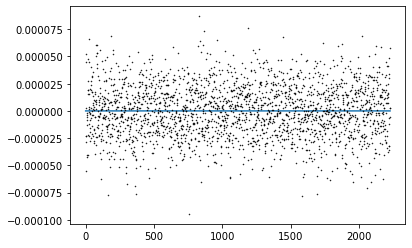

In [138]:
plt.plot(med-med)
plt.plot(y-med, '.k', ms=1)

In [143]:
def svd2_lowdim_deproject_model(p, mu_eta, sigma_eta, H, mu_beta, Sigma_beta):
    # hack for non-negativity
    beta = numpyro.sample("beta", dist.TruncatedNormal(0, 10., low=0), sample_shape=(p,))
    # from the datafit
    nrm = dist.Normal(mu_eta, sigma_eta)
    numpyro.factor("likelihood", jnp.sum(nrm.log_prob(jnp.dot(H, beta))))
    # prior
    beta_prior = dist.MultivariateNormal(mu_beta, Sigma_beta)
    numpyro.factor("regulariser", beta_prior.log_prob(beta))
    return beta

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(svd2_lowdim_deproject_model)
svd2_lowdim_deproject_mcmc = MCMC(kernel, num_warmup=500, num_samples=500)

In [144]:
smp = svd2_lowdim_datafit_mcmc.get_samples()
mu_eta, sigma_eta = np.mean(smp['eta'], 0), np.std(smp['eta'], 0)

In [145]:
mu_eta, sigma_eta, sigma_y

(DeviceArray([-30.06753  , -17.27958  ,  -1.8137609,  -1.1856014,
               -5.12149  ,  -9.116992 , -22.969938 , -20.967075 ,
              -21.595583 ,  11.766979 ,   3.8214388,  30.18861  ,
               13.957201 , -32.128933 , -10.4152355], dtype=float32),
 DeviceArray([2.0580359e-03, 3.0909469e-02, 1.7173804e-01, 3.0871776e-01,
              6.9838035e-01, 8.1235331e-01, 1.2142712e+00, 1.8740197e+00,
              2.3011260e+00, 2.7486780e+00, 3.0330453e+00, 3.5052695e+00,
              4.3248935e+00, 4.4691372e+00, 4.9724884e+00], dtype=float32),
 2.4414070515370626e-05)

In [146]:
p = ssps.X.shape[1]
svd2_lowdim_deproject_mcmc.run(
    rng_key_, p, mu_eta, sigma_eta, H2, jnp.zeros(p), Sigma_beta
)

sample: 100%|█████████████| 1000/1000 [04:42<00:00,  3.53it/s, 1023 steps of size 4.26e-07. acc. prob=0.90]


In [147]:
svd2_lowdim_deproject_mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.11      0.00      0.11      0.11      0.11      0.50      1.00
   beta[1]      0.09      0.00      0.09      0.09      0.09      0.50      1.00
   beta[2]      0.07      0.00      0.07      0.07      0.07      0.50      1.00
   beta[3]      0.06      0.00      0.06      0.06      0.06      0.50      1.00
   beta[4]      0.05      0.00      0.05      0.05      0.05      0.50      1.00
   beta[5]      0.04      0.00      0.04      0.04      0.04      0.50      1.00
   beta[6]      0.04      0.00      0.04      0.04      0.04      0.50      1.00
   beta[7]      0.25      0.00      0.25      0.25      0.25      0.50      1.00
   beta[8]      1.09      0.00      1.09      1.09      1.09      0.72      1.01
   beta[9]      0.26      0.00      0.26      0.26      0.26      0.50      1.00
  beta[10]      0.11      0.00      0.11      0.11      0.11      0.50      1.00
  beta[11]      0.10      0